In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

In [3]:
from train_on_L5 import IFDNN

In [5]:
model = torch.load("L5_model.pt", map_location=torch.device('cpu'))

In [101]:
conv1 = list(model.parameters())[0].detach().numpy()
conv2 = list(model.parameters())[2].detach().numpy()
conv3 = list(model.parameters())[4].detach().numpy()

In [109]:
conv3.shape

(1, 8, 100)

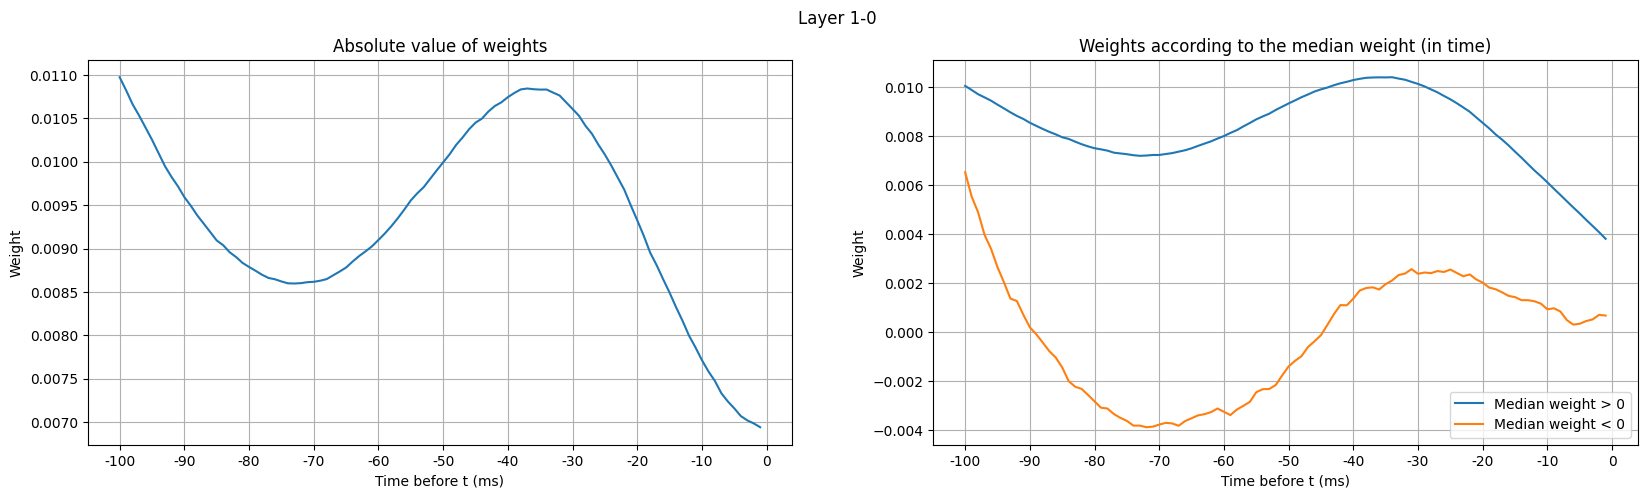

In [123]:
layer = conv1
filt = 0

fig, ax = plt.subplots(1, 2, figsize = (20, 5))

fig.suptitle(f"Layer 1-{filt}")

ax[0].plot(np.abs(layer[filt]).mean(axis = 0))
ax[0].set_title(f"Absolute value of weights")

ax[1].plot(np.mean(layer[filt][np.median(layer[filt], axis = 1) > 0], axis = 0), label = "Median weight > 0")
ax[1].plot(np.mean(layer[filt][np.median(layer[filt], axis = 1) < 0], axis = 0), label = "Median weight < 0")
ax[1].set_title(f"Weights according to the median weight (in time)")
ax[1].legend()

for i in range(2):
    ax[i].set_xlabel("Time before t (ms)")
    ax[i].set_xticks(np.arange(0, 110, 10))
    ax[i].set_xticklabels(np.arange(-100, 10, 10))
    ax[i].set_ylabel("Weight")
    ax[i].grid()

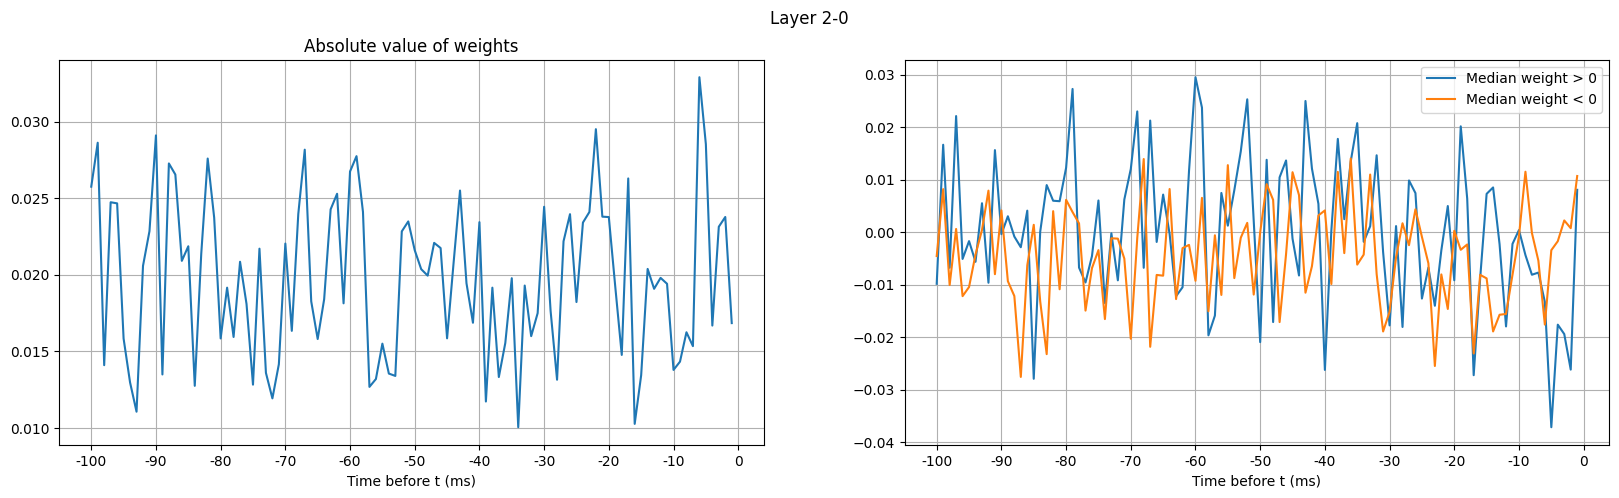

In [114]:
layer = conv2
filt = 0

fig, ax = plt.subplots(1, 2, figsize = (20, 5))

fig.suptitle(f"Layer 2-{filt}")

ax[0].plot(np.abs(layer[filt]).mean(axis = 0))
ax[0].set_title(f"Absolute value of weights")

ax[1].plot(np.mean(layer[filt][np.median(layer[filt], axis = 1) > 0], axis = 0), label = "Median weight > 0")
ax[1].plot(np.mean(layer[filt][np.median(layer[filt], axis = 1) < 0], axis = 0), label = "Median weight < 0")
ax[1].legend()

for i in range(2):
    ax[i].set_xlabel("Time before t (ms)")
    ax[i].set_xticks(np.arange(0, 110, 10))
    ax[i].set_xticklabels(np.arange(-100, 10, 10))
    ax[i].grid()

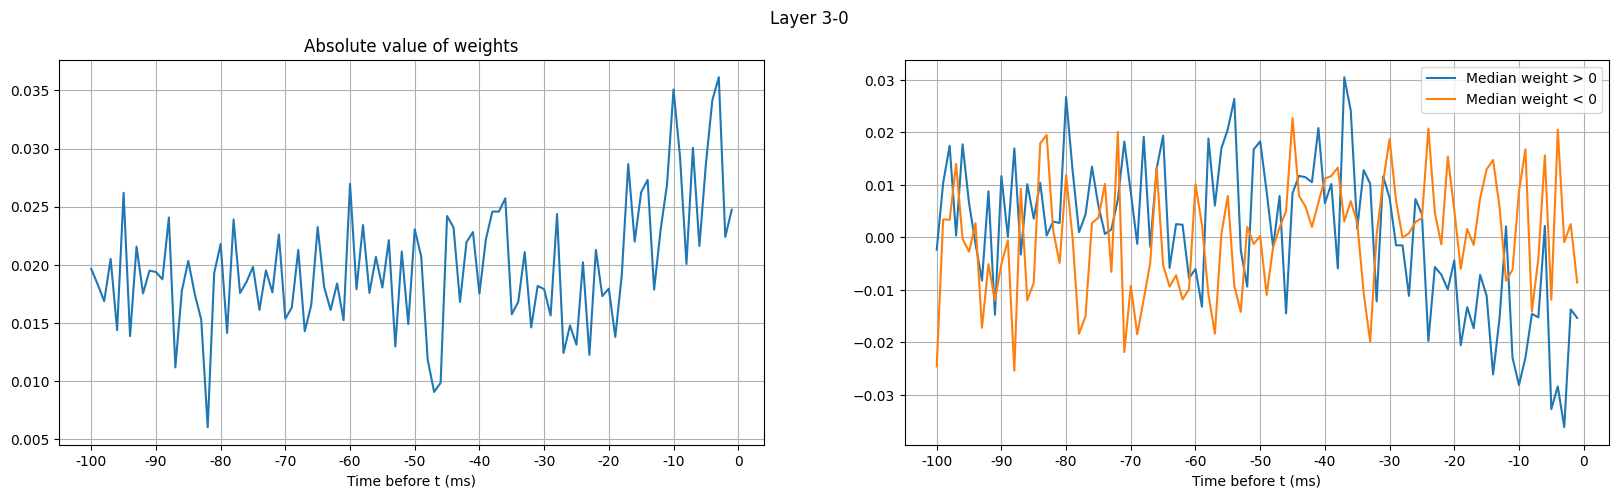

In [139]:
layer = conv3
filt = 0

fig, ax = plt.subplots(1, 2, figsize = (20, 5))

fig.suptitle(f"Layer 3-{filt}")

ax[0].plot(np.abs(layer[filt]).mean(axis = 0))
ax[0].set_title(f"Absolute value of weights")

ax[1].plot(np.mean(layer[filt][np.median(layer[filt], axis = 1) > 0], axis = 0), label = "Median weight > 0")
ax[1].plot(np.mean(layer[filt][np.median(layer[filt], axis = 1) < 0], axis = 0), label = "Median weight < 0")
ax[1].legend()

for i in range(2):
    ax[i].set_xlabel("Time before t (ms)")
    ax[i].set_xticks(np.arange(0, 110, 10))
    ax[i].set_xticklabels(np.arange(-100, 10, 10))
    ax[i].grid()

In [3]:
sim_time_ms = 5000
N_exc_syn = 80
N_inh_syn = 20
N_syn = N_exc_syn + N_inh_syn
exc_w = 1.0
inh_w = -1.0
R = 2

V_peak = -60
V_reset = -75

win_size = 80

In [4]:
np.random.seed(123)
exc_CI = exc_w * generate_current_inj_matrix(3, N_exc_syn, sim_time_ms)
inh_CI = inh_w * generate_current_inj_matrix(3, N_inh_syn, sim_time_ms)

In [5]:
exc_CI.shape

(80, 5000)

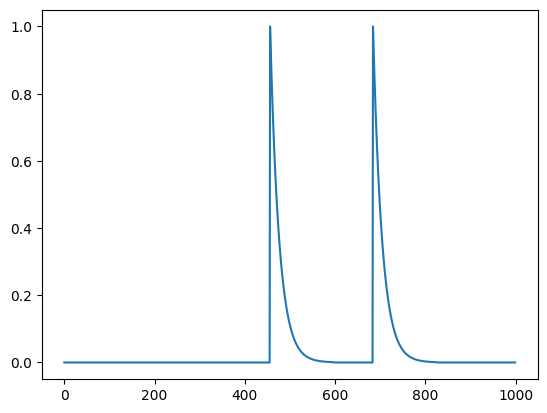

In [23]:
plt.plot(exc_CI[0, :1000])

In [24]:
class IF:
    
    def __init__(self, V_peak, V_reset) -> None:
        self.V_peak = V_peak
        self.V_reset = V_reset
        self.V = V_reset
    
    def update_voltage(self, I_t):
        raise NotImplementedError
    
    def simulate(self, I):
        V_out = [self.V]
        spike_times = []
        T = len(I)

        was_peak = False

        for t in range(T):
            if was_peak:
                V_out.append(self.V)
                was_peak = False
                continue
            self.update_voltage(I[t])
            if self.V >= self.V_peak:
                V_out.append(self.V_peak)
                spike_times.append(t)
                self.V = self.V_reset
                was_peak = True
            else:
                V_out.append(self.V)
        
        return np.array(V_out[1:]), np.array(spike_times)

In [25]:
class QuadraticIF(IF):

    def update_voltage(self, I_t):
        self.V += I_t + self.V ** 2 # wrong

class LeakyIF(IF):

    def update_voltage(self, I_t):
        self.V = self.V + I_t - (self.V - self.V_reset) / R

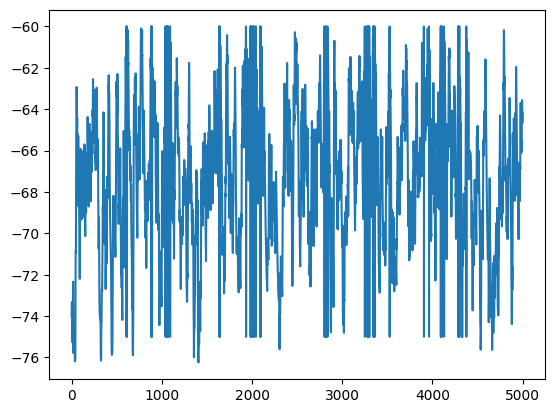

In [26]:
lif = LeakyIF(V_peak = V_peak, V_reset = V_reset)

I_input = np.vstack((exc_CI, inh_CI)).sum(axis = 0)

V_out, spike_times = lif.simulate(I = I_input)
plt.plot(V_out)

In [27]:
spike_times

array([ 608,  612,  881,  886,  890, 1040, 1051, 1056, 1061, 1065, 1070,
       1091, 1636, 1643, 1933, 1983, 1988, 1992, 2009, 2015, 2019, 2041,
       2090, 2095, 2803, 2813, 2822, 2836, 3250, 3277, 3280, 3284, 3288,
       3291, 3295, 3299, 3344, 3353, 3357, 3525, 3905, 3961, 4092, 4096,
       4101, 4128, 4287, 4291, 4298, 4375])

In [28]:
def generate_dataset(size):

    I_input = np.zeros((size, N_syn, sim_time_ms))
    V_ouput = np.zeros((size, sim_time_ms))
    spikes_out = np.zeros((size, sim_time_ms))

    for i in tqdm(range(size)):
        np.random.seed(np.random.randint(50, 450))
        exc_CI = exc_w * generate_current_inj_matrix(3, N_exc_syn, sim_time_ms)
        inh_CI = inh_w * generate_current_inj_matrix(3, N_inh_syn, sim_time_ms)
        
        CI = np.vstack((exc_CI, inh_CI))
        I_input[i] = CI

        lif = LeakyIF(V_peak = V_peak, V_reset = V_reset)
        V_out, spikes = lif.simulate(CI.sum(axis = 0))
        V_ouput[i] = V_out.flatten()
        if len(spikes) > 0:
            spikes_out[i, spikes] = 1
    
    return I_input, V_ouput, spikes_out

In [29]:
I_input, V_ouput, spikes_out = generate_dataset(1)

100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


In [30]:
I_input.shape

(1, 100, 5000)

In [31]:
V_ouput.shape

(1, 5000)

In [32]:
spikes_out.shape

(1, 5000)

In [10]:
class IFDNN(torch.nn.Module):

    def __init__(self, N_syn, win_size):
        super().__init__()
        self.win_size = win_size
        self.conv = torch.nn.Conv1d(in_channels = N_syn, out_channels = 1, kernel_size = self.win_size, padding = "valid")
        self.spike_conv = torch.nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 1, padding = "valid")
        self.v_conv = torch.nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 1, padding = "valid")

    def forward(self, I_input):
        # Causal padding, so that the kernel uses [... t-1] to predict [t]
        I_input = torch.nn.functional.pad(I_input, (self.win_size - 1, 0))
        out = self.conv(I_input)

        spike_out = self.spike_conv(out)
        spike_out = torch.nn.functional.logsigmoid(spike_out)

        v_out = self.v_conv(out)

        return v_out, spike_out
    
model = IFDNN(N_syn = N_syn, win_size = win_size)

In [11]:
# https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/8
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
count_parameters(model)

8005

In [13]:
all_train_loss = []
all_test_loss = []

model = IFDNN(N_syn = N_syn, win_size = win_size)
I_input_test, V_ouput_test, spike_times_test = generate_dataset(32)

100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


In [14]:
for batch_num in range(10):

    I_input_train, V_ouput_train, spike_times_train = generate_dataset(32)

    train_loss_history, test_loss_history = train(
        num_epoch = 15,
        model = model,
        device_name = "cpu",
        lr = 0.0001, # 0.0003
        I_train = I_input_train,
        V_train = V_ouput_train,
        spike_times_train = spike_times_train,
        I_test = I_input_test,
        V_test = V_ouput_test,
        spike_times_test = spike_times_test,
        sim_time_ms = sim_time_ms
    )

    all_train_loss.extend(train_loss_history)
    all_test_loss.extend(test_loss_history)

100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


[Epoch 0]:
              train_loss = 8312.8779296875,
              test_MSE = 4653.646484375,
              test_BCE = 3560.997802734375,
              test_loss = 8214.64453125,
              test_acc = 0.99223125
              test_AUC = 0.5215743231415706
[Epoch 1]:
              train_loss = 8217.353515625,
              test_MSE = 4647.244140625,
              test_BCE = 3476.518798828125,
              test_loss = 8123.7626953125,
              test_acc = 0.99223125
              test_AUC = 0.5358913307759657
[Epoch 2]:
              train_loss = 8123.45751953125,
              test_MSE = 4640.8505859375,
              test_BCE = 3393.54638671875,
              test_loss = 8034.39697265625,
              test_acc = 0.99223125
              test_AUC = 0.5493274934352608
[Epoch 3]:
              train_loss = 8031.19921875,
              test_MSE = 4634.4677734375,
              test_BCE = 3312.0869140625,
              test_loss = 7946.5546875,
              test_acc = 0.99223125

 25%|██▌       | 8/32 [00:03<00:11,  2.14it/s]


KeyboardInterrupt: 

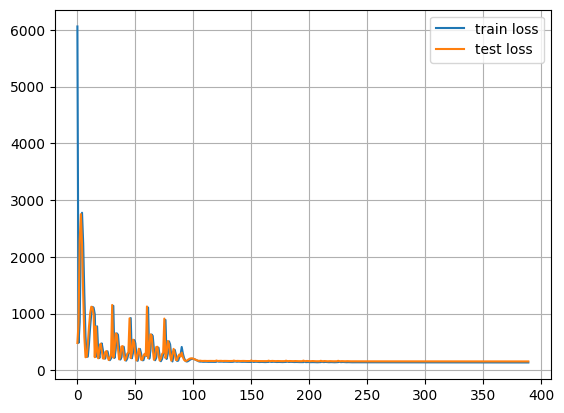

In [29]:
plt.plot(all_train_loss, label = "train loss")
plt.plot(all_test_loss, label = "test loss")
plt.grid()
plt.legend()

In [30]:
conv_params = list(model.parameters())[0].detach().numpy()[0]
conv_params.shape

(100, 80)

In [31]:
np.median(conv_params)

0.18005961

In [32]:
conv_params

array([[ 0.54131   ,  0.47349748,  0.41318563, ...,  0.44084486,
         0.49930152,  0.56764746],
       [ 1.0470155 ,  0.948186  ,  0.8823584 , ...,  0.50625366,
         0.58276355,  0.6844535 ],
       [ 0.7273737 ,  0.6418907 ,  0.5769223 , ...,  0.8703752 ,
         0.9998561 ,  1.1431091 ],
       ...,
       [-1.0391077 , -0.90187323, -0.81583726, ..., -1.1479957 ,
        -1.273328  , -1.364298  ],
       [-0.41437674, -0.35250315, -0.28700277, ..., -1.4693499 ,
        -1.6054579 , -1.7222424 ],
       [-0.5548225 , -0.50515604, -0.4474204 , ..., -2.075593  ,
        -2.2380078 , -2.3876126 ]], dtype=float32)

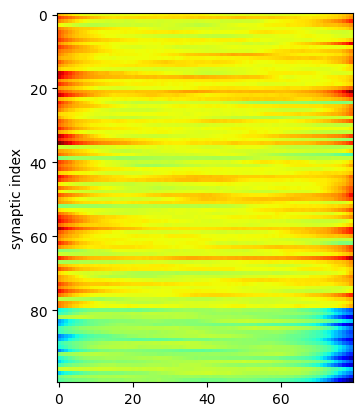

In [42]:
import seaborn as sns
plt.imshow(conv_params, cmap = 'jet')
plt.ylabel("synaptic index");

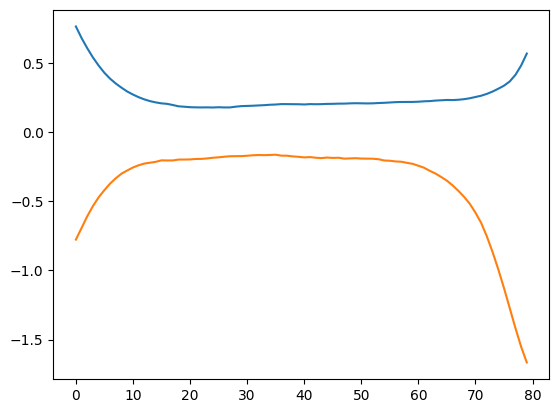

In [40]:
exc_params = conv_params[:80]
inh_params = conv_params[80:]
plt.plot(exc_params.mean(axis = 0))
plt.plot(inh_params.mean(axis = 0))

24068021


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


[Epoch 0]:
              train_loss = 7827.56298828125,
              test_MSE = 5395.0341796875,
              test_BCE = 577.7308959960938,
              test_loss = 5972.76513671875,
              test_acc = 0.99425
              test_AUC = 0.6075149500934722
[Epoch 0]:
              train_loss = 6376.6494140625,
              test_MSE = 4894.3251953125,
              test_BCE = 197.52513122558594,
              test_loss = 5091.85009765625,
              test_acc = 0.99425
              test_AUC = 0.5854205157918904


In [5]:
torch.tensor(spike_times_train).shape

torch.Size([1, 4000])